# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [44]:
%pip install "protobuf<=3.20.1" --force-reinstall

  Using cached protobuf-3.20.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (698 bytes)
Using cached protobuf-3.20.1-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
Note: you may need to restart the kernel to use updated packages.


In [45]:
import protobuf

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 import protobuf                                                                              │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'protobuf'

In [29]:
!pip install smdebug

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
  DEPRECATION: Building 'pyinstrument-cext' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pyinstrument-cext'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6353 sha256=f53dd2b3930e1de4ad798899b848a46731a8569c5f108f326ac3c21c172ed2a0
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: pr

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
#!pip install smdebug
#!pip install kaggle
!pip install kagglehub

In [46]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

In [47]:
import sagemaker
from sagemaker.session import Session
from sagemaker import get_execution_role

session = sagemaker.Session()
bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-463470961997
AWS Region: us-east-1
RoleArn: arn:aws:iam::463470961997:role/service-role/AmazonSageMaker-ExecutionRole-20250621T132237


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import os
import json
kaggle_username = "danny123"
kaggle_key = "5d3c10745134cd54a15f110356c894b5"

kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

# Save API token the kaggle.json file
with open(kaggle_path, "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [9]:
#!kaggle datasets download sameeharahman/preprocessed-snake-images
#!unzip preprocessed-snake-images.zip -d snakeImages
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sameeharahman/preprocessed-snake-images")

In [10]:
import os

print("Downloaded path:", path)
print("Contents:")
print(os.listdir(path))


Downloaded path: /home/ec2-user/.cache/kagglehub/datasets/sameeharahman/preprocessed-snake-images/versions/1
Contents:
['preprocessed-cleaned-set']


In [11]:
import shutil

# Define source and target
#src = "/home/sagemaker-user/.cache/kagglehub/datasets/sameeharahman/preprocessed-snake-images/versions/1/preprocessed-cleaned-set"
src = "/home/ec2-user/.cache/kagglehub/datasets/sameeharahman/preprocessed-snake-images/versions/1/preprocessed-cleaned-set"
dst = "data/snakeImages"

# Create destination folder if not exists
os.makedirs(dst, exist_ok=True)

# Move contents from the source to the destination
for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
        shutil.move(s, d)
    else:
        shutil.copy2(s, d)

print("Moved data to:", dst)

Moved data to: data/snakeImages


In [12]:
for root, dirs, files in os.walk("data/snakeImages"):
    level = root.replace("data/snakeImages", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:3]:  # Show up to 3 files per folder
        print(f"{subindent}{f}")

snakeImages/
    train/
        class-3/
            575cc0376f0404ddcf425696b283e040.jpg
            7e03ab00e1ecec99912809e34a86ac9a.jpg
            2e28cba7f6f6783f8ddb41997f8e9c72.jpg
        class-1/
            868e3b0ea30855e8674f7d47a396c31c.jpg
            5880c93ba0276eb64d17ef32a193c163.jpg
            52f2d926981807968c0c1ddc07bd37b3.jpg
        class-4/
            4e63f623ca96edaa3ddd79aaef094189.jpg
            4cd2edf8355f12ef00910c47036de421.jpg
            56678ffc3cacec76e8b8abe7b34ff686.jpg
        class-2/
            e31b84eb2902195e4df0acda26c6c304.jpg
            f983d8f124e3a5809a5cf618ebaef7cd.jpg
            31f462a635938db452517e9b249bf7c9.jpg
        class-5/
            597ddedb24a4a5a89dd830f53fc53619.jpg
            713bccf11ce0bc3f0e37c27b224ad112.jpg
            c60dae50ac705a8f2faf1b92f23086d2.jpg


In [13]:
#count number of images in each folder
from glob import glob

# Path to your training directory
train_dir = "data/snakeImages/train"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue  # skip files like .DS_Store if any

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-3: 3547 images
class-1: 3087 images
class-4: 3453 images
class-2: 3661 images
class-5: 3641 images


In [14]:
###Move 10% to test
# Paths
import random
base_dir = "data/snakeImages/train"
test_dir = "data/snakeImages/test"
os.makedirs(test_dir, exist_ok=True)

# Set random seed for reproducibility
random.seed(42)

# Step 1 & 2: For each class folder
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    # Gather all image files (excluding .ipynb_checkpoints and non-images)
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    # Count and print
    print(f"{class_name}: {len(image_files)} images")

    # Determine 10% sample for test set
    num_test = max(1, int(0.1 * len(image_files)))  # At least one image
    test_samples = random.sample(image_files, num_test)

    # Create test/class_name folder
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move files
    for file_path in test_samples:
        filename = os.path.basename(file_path)
        shutil.move(file_path, os.path.join(test_class_dir, filename))

    print(f"→ Moved {num_test} images to test/{class_name}/")

print("\nDone splitting into train and test sets.")

class-3: 3547 images
→ Moved 354 images to test/class-3/
class-1: 3087 images
→ Moved 308 images to test/class-1/
class-4: 3453 images
→ Moved 345 images to test/class-4/
class-2: 3661 images
→ Moved 366 images to test/class-2/
class-5: 3641 images
→ Moved 364 images to test/class-5/

Done splitting into train and test sets.


In [15]:
train_dir = "data/snakeImages/train"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue 

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-3: 3193 images
class-1: 2779 images
class-4: 3108 images
class-2: 3295 images
class-5: 3277 images


In [16]:
test_dir = "data/snakeImages/test"

# Loop through each class folder and count .jpg images
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    
    if not os.path.isdir(class_path):
        continue  

    # Get all .jpg files, excluding .ipynb_checkpoints
    image_files = glob(os.path.join(class_path, "*.jpg"))
    image_files = [f for f in image_files if ".ipynb_checkpoints" not in f]

    print(f"{class_name}: {len(image_files)} images")

class-3: 354 images
class-1: 308 images
class-4: 345 images
class-2: 366 images
class-5: 364 images


In [17]:
for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:3]:  # Show up to 3 files per folder
        print(f"{subindent}{f}")

data/
    snakeImages/
        train/
            class-3/
                575cc0376f0404ddcf425696b283e040.jpg
                7e03ab00e1ecec99912809e34a86ac9a.jpg
                689a1740d932ba9746781ee2281e1051.jpg
            class-1/
                868e3b0ea30855e8674f7d47a396c31c.jpg
                52f2d926981807968c0c1ddc07bd37b3.jpg
                b17f70ccb341367b2d943c2912f82aad.jpg
            class-4/
                4e63f623ca96edaa3ddd79aaef094189.jpg
                4cd2edf8355f12ef00910c47036de421.jpg
                56678ffc3cacec76e8b8abe7b34ff686.jpg
            class-2/
                e31b84eb2902195e4df0acda26c6c304.jpg
                f983d8f124e3a5809a5cf618ebaef7cd.jpg
                31f462a635938db452517e9b249bf7c9.jpg
            class-5/
                597ddedb24a4a5a89dd830f53fc53619.jpg
                713bccf11ce0bc3f0e37c27b224ad112.jpg
                c60dae50ac705a8f2faf1b92f23086d2.jpg
        test/
            class-3/
                2e28cba7f6f

In [ ]:
#upload to S3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./data/snakeImages/train s3://{bucket}/train/
!aws s3 sync ./data/snakeImages/test s3://{bucket}/test/

upload: data/snakeImages/train/class-1/001c80c16f964bb570d7eadcc09d0557.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/001c80c16f964bb570d7eadcc09d0557.jpg
upload: data/snakeImages/train/class-1/00df0029772f1dd8e238a5bdca5a622b.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/00df0029772f1dd8e238a5bdca5a622b.jpg
upload: data/snakeImages/train/class-1/018851c5f0d3b7d2d011e9a72d6b4aa7.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/018851c5f0d3b7d2d011e9a72d6b4aa7.jpg
upload: data/snakeImages/train/class-1/00056e9548477cda7a885bb423cb668c.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/00056e9548477cda7a885bb423cb668c.jpg
upload: data/snakeImages/train/class-1/00f4b755cf5e796f940b4e63e58d8260.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/00f4b755cf5e796f940b4e63e58d8260.jpg
upload: data/snakeImages/train/class-1/00f42a37d55bf8d348bf616ed7603119.jpg to s3://sagemaker-us-east-1-463470961997/train/class-1/00f42a37d55bf8d348bf616ed7603

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [19]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter,CategoricalParameter
from sagemaker.pytorch import PyTorch

In [50]:
hyperparameter_ranges = {
    'batch-size': CategoricalParameter([32, 64, 128]),
    'learning-rate': ContinuousParameter(0.0001, 0.01)
}
metric_definitions = [{'Name': 'test_loss','Regex': 'test_loss: ([0-9\\.]+)'}]
objective_metric_name = 'test_loss'
objective_type = 'Minimize'

In [53]:
#TODO: Create estimators for your HPs

estimator = PyTorch(entry_point = 'hpo.py',
                    base_job_name='hpo_snake_classify',
                    role=role,
                    py_version='py36',
                    framework_version="1.8",
                    instance_count=1,
                    instance_type="ml.m5.xlarge")

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [26]:
s3_input_path = f"s3://{bucket}/" 
s3_input_path

's3://sagemaker-us-east-1-463470961997/'

In [55]:
tuner.fit({"training": s3_input_path}, wait=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [64]:
from sagemaker.tuner import HyperparameterTuningJobAnalytics

tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-250526-0739',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:438465162826:hyper-parameter-tuning-job/pytorch-training-250526-0739',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'test_loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 2},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning-rate',
     'MinValue': '0.0001',
     'MaxValue': '0.01',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch-size',
     'Values': ['"32"', '"64"', '"128"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'test_loss',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"PyTorch"',
   'sagemaker_estimator_module': '"sagemaker.pyt

In [65]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-250526-0739


In [66]:
best_estimator=tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-05-26 14:07:34 Starting - Found matching resource for reuse
2025-05-26 14:07:34 Downloading - Downloading the training image
2025-05-26 14:07:34 Training - Training image download completed. Training in progress.
2025-05-26 14:07:34 Uploading - Uploading generated training model
2025-05-26 14:07:34 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"test_loss"',
 'batch-size': '"128"',
 'learning-rate': '0.003953136913916208',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_snake_classify-2025-05-26-07-39-12-415"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-438465162826/hpo_snake_classify-2025-05-26-07-39-12-415/source/sourcedir.tar.gz"'}

In [72]:
best_estimator.hyperparameters()['batch-size'],best_estimator.hyperparameters()['learning-rate']

('"128"', '0.003953136913916208')

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig,ProfilerRule,CollectionConfig,rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]


collection_configs = [
    CollectionConfig(
        name="train_loss",  # Custom collection for training loss
        parameters={"include_regex": ".*CrossEntropyLoss_output.*", "save_interval": "10"}
    ),
    CollectionConfig(
        name="eval_losses",  # Custom collection for evaluation loss
        parameters={"include_regex": ".*CrossEntropyLoss_output.*", "save_interval": "10"}
    )
]

In [21]:
hook_config = DebuggerHookConfig(collection_configs=collection_configs)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [71]:
hyperparameters = {
    "batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
    "learning-rate": float(best_estimator.hyperparameters()['learning-rate'].replace('"', ''))
}
hyperparameters

{'batch-size': 128, 'learning-rate': 0.003953136913916208}

In [23]:
hyperparameters = {
    "batch-size": int(128),
    "learning-rate": float(0.003953136913916208)
}
hyperparameters

{'batch-size': 128, 'learning-rate': 0.003953136913916208}

In [24]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='snake-classifier',  
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.8',
    py_version='py36',
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [27]:
#s3_input_path
estimator.fit({"training": s3_input_path}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: snake-classifier-2025-06-22-00-14-59-478


In [37]:
import protobuf
print(protobuf.__version__)
print(protobuf.__file__)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 import protobuf                                                                              │
│   2 print(protobuf.__version__)                                                                  │
│   3 print(protobuf.__file__)                                                                     │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'protobuf'

In [36]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
#from smdebug.core.modes import ModeKeys
#trial = create_trial(estimator.latest_job_debugger_artifacts_path())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 # TODO: Plot a debugging output.                                                             │
│ ❱ 2 from smdebug.trials import create_trial                                                      │
│   3 #from smdebug.core.modes import ModeKeys                                                     │
│   4 #trial = create_trial(estimator.latest_job_debugger_artifacts_path())                        │
│   5                                                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/smdebug/trials/__init__.py:2  │
│ in <module>                                                                                      │
│                                                                                                  │
│   1 # Local                                                                                      │
│ ❱ 2 from .local_trial import LocalTrial                                                          │
│   3 from .s3_trial import S3Trial                                                                │
│   4 from .trial import Trial                                                                     │
│   5 from .utils import create_trial                                                              │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/smdebug/trials/local_trial.py │
│ :6 in <module>                                                                                   │
│                                                                                                  │
│    3                                                                                             │
│    4 # First Party                                                                               │
│    5 from smdebug.core.collection_manager import CollectionManager                               │
│ ❱  6 from smdebug.core.index_reader import LocalIndexReader                                      │
│    7 from smdebug.core.utils import get_path_to_collections, list_collection_files_in_directo    │
│    8                                                                                             │
│    9 # Local                                                                                     │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/smdebug/core/index_reader.py: │
│ 23 in <module>                                                                                   │
│                                                                                                  │
│    20 from smdebug.core.logger import get_logger                                                 │
│    21 from smdebug.core.modes import ModeKeys                                                    │
│    22 from smdebug.core.s3_utils import list_s3_objects                                          │
│ ❱  23 from smdebug.core.tfrecord.tensor_reader import TensorReader                               │
│    24 from smdebug.core.utils import (                                                           │
│    25 │   get_path_to_events_directory,                                                          │
│    26 │   is_s3,                                                                                 │
│                                                            

In [87]:
trial.tensor_names()

[2025-05-29 17:39:06.678 default:141 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-05-29 17:39:07.696 default:141 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [31]:
trial.tensor_names()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 trial.tensor_names()                                                                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trial' is not defined

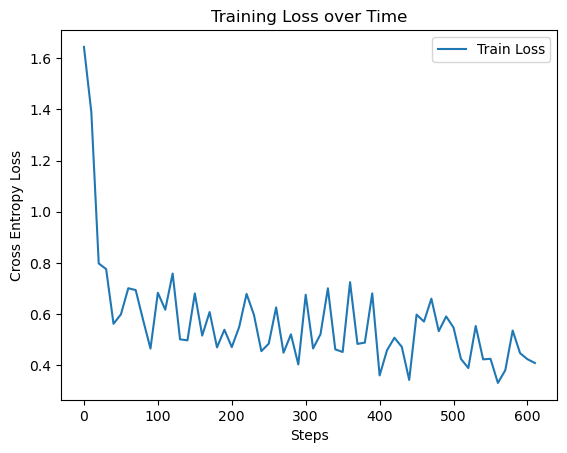

In [92]:
import matplotlib.pyplot as plt

# Example: Plot training loss
steps = trial.steps(mode=ModeKeys.TRAIN)
loss_vals = [trial.tensor("CrossEntropyLoss_output_0").value(step) for step in steps]

plt.plot(steps, loss_vals, label='Train Loss')
plt.xlabel("Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

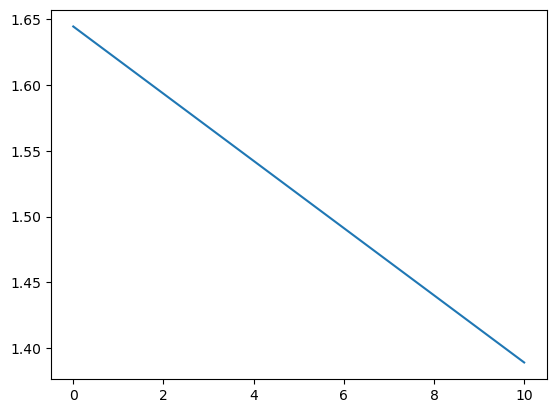

In [89]:
steps = trial.steps(mode=ModeKeys.EVAL)
loss_vals = [trial.tensor("CrossEntropyLoss_output_0").value(step) for step in steps]
plt.plot(steps, loss_vals, label='Eval Loss')
# plt.plot(steps, loss_vals, label='Train Loss')
# plt.xlabel("Steps")
# plt.ylabel("Cross Entropy Loss")
# plt.title("Training Loss over Time")
# plt.legend()
# plt.show()

In [94]:
len(loss_vals)

62

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [97]:
# TODO: Display the profiler output
#estimator.output_path,estimator.latest_training_job.job_name
#s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-report.html
prof_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [99]:
!aws s3 cp {prof_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-438465162826/sn

In [101]:
from IPython.display import IFrame

# Show the profiler report in an embedded frame
IFrame(src='./ProfilerReport/profiler-output/profiler-report.html', width=1000, height=600)

## Model Deploying

In [48]:
from sagemaker.pytorch import PyTorchModel

In [120]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model path: {model_data}")

Model path: s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/output/model.tar.gz


In [121]:
# TODO: Deploy your model to an endpoint

pytorch_model = PyTorchModel(
    entry_point='inference.py',
    model_data=model_data, 
    role=role,
    framework_version='1.8',         # Match your local PyTorch version if needed
    py_version='py36'
)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge",endpoint_name='resnet50-snake-custom-endpoint')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-438465162826/snake-classifier-2025-05-29-05-45-39-557/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-438465162826/pytorch-inference-2025-06-02-03-29-03-069/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-06-02-03-29-10-795
INFO:sagemaker:Creating endpoint-config with name resnet50-snake-custom-endpoint
INFO:sagemaker:Creating endpoint with name resnet50-snake-custom-endpoint


------!

In [109]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import requests
import base64
import io

In [142]:
# Pick a test image
test_image_path = './data/snakeImages/test/class-5/1c758f902321e876e21d47d0e9ce636e.jpg'  # Replace with your actual path

# Open image and convert to bytes
with open(test_image_path, 'rb') as f:
    payload = f.read()


In [141]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import StringDeserializer
predictor.deserializer = StringDeserializer()
predictor.serializer = IdentitySerializer(content_type='image/jpeg')

In [144]:
response=predictor.predict(payload)
print(response)

{"class_index": 4, "class_label": "Western Diamondback rattlesnake", "confidence": 0.973}


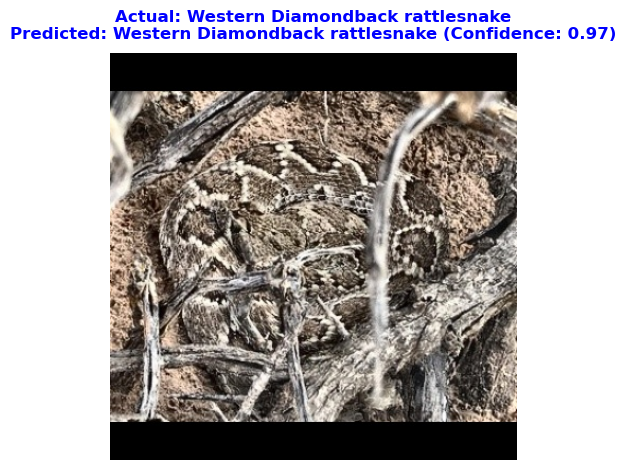

In [147]:
# Step 1: Define the label lookup
label_lookup = {
    0: "Northern Watersnake",
    1: "Common Garter snake",
    2: "DeKay's Brown snake",
    3: "Black Rat snake",
    4: "Western Diamondback rattlesnake"
}

# Step 2: Provide image path
test_image_path = './data/snakeImages/test/class-5/1c758f902321e876e21d47d0e9ce636e.jpg'

# Step 3: Extract actual class from image path
actual_class_index = int(test_image_path.split("class-")[1].split("/")[0])
actual_class_label = label_lookup[actual_class_index-1]

# Step 4: Read image bytes and send to endpoint
with open(test_image_path, 'rb') as f:
    payload = f.read()

response = predictor.predict(payload)
prediction = json.loads(response)

predicted_class_index = prediction["class_index"]
predicted_class_label = prediction["class_label"]
confidence = prediction["confidence"]

# Step 5: Show image and overlay actual vs predicted info
image = Image.open(test_image_path)

plt.imshow(image)
plt.axis("off")
plt.title(
    f"Actual: {actual_class_label}\n"
    f"Predicted: {predicted_class_label} (Confidence: {confidence:.2f})",
    fontsize=12,
    color='blue'
)
plt.show()

In [149]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: resnet50-snake-custom-endpoint
INFO:sagemaker:Deleting endpoint with name: resnet50-snake-custom-endpoint


In [148]:
test_image_path = './data/snakeImages/test/class-1/0b22ab2824da7b9db11b0ab563dfb1fb.jpg'  # Replace with your actual path

# Open image and convert to bytes
with open(test_image_path, 'rb') as f:
    payload = f.read()

response=predictor.predict(payload)
print(response)

{"class_index": 0, "class_label": "Northern Watersnake", "confidence": 0.993}


In [52]:
model_data = estimator.model_data
print(model_data)

s3://sagemaker-us-east-1-463470961997/snake-classifier-2025-06-22-00-14-59-478/output/model.tar.gz


In [53]:
#import boto3

s3_client = boto3.client('s3')
#bucket = 'your-bucket'
key = 'snake-classifier-2025-06-22-00-14-59-478/output/model.tar.gz'
s3_client.download_file(bucket, key, 'model.tar.gz')

In [64]:
from sagemaker.model import Model

model = Model(
    image_uri='463470961997.dkr.ecr.us-east-1.amazonaws.com/snake-inference:latest',
    role=role,  # your SageMaker role
)

In [77]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name='snake-custom-endpoint'
)

INFO:sagemaker:Creating model with name: snake-inference-2025-06-22-07-30-52-029
INFO:sagemaker:Creating endpoint-config with name snake-custom-endpoint


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictor = model.deploy(                                                                    │
│   2 │   initial_instance_count=1,                                                                │
│   3 │   instance_type='ml.m5.large',                                                             │
│   4 │   endpoint_name='snake-custom-endpoint'                                                    │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/model.py:1814 in    │
│ deploy                                                                                           │
│                                                                                                  │
│   1811 │   │   │   │   )                                                                         │
│   1812 │   │   │   │   self.sagemaker_session.update_endpoint(self.endpoint_name, endpoint_conf  │
│   1813 │   │   │   else:                                                                         │
│ ❱ 1814 │   │   │   │   self.sagemaker_session.endpoint_from_production_variants(                 │
│   1815 │   │   │   │   │   name=self.endpoint_name,                                              │
│   1816 │   │   │   │   │   production_variants=[production_variant],                             │
│   1817 │   │   │   │   │   tags=tags,                                                            │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:6031 in  │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   6028 │   │   │   config_options["ExecutionRoleArn"] = role                                     │
│   6029 │   │                                                                                     │
│   6030 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│ ❱ 6031 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   6032 │   │                                                                                     │
│   6033 │   │   return self.create_endpoint(                                                      │
│   6034 │   │   │   endpoint_name=name,                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:598 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    595 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    596 │   │   │   │   )                                                                         │
│    597 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  598 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    599 │   │                                                                                     │
│    600 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    601                                                     

In [71]:
# Pick a test image
test_image_path = './data/snakeImages/test/class-5/0f3fda23465ceda0832bd1efde2028d4.jpg'  # Replace with your actual path

# Open image and convert to bytes 
with open(test_image_path, 'rb') as f:
    payload = f.read()

INFO:matplotlib.font_manager:generated new fontManager


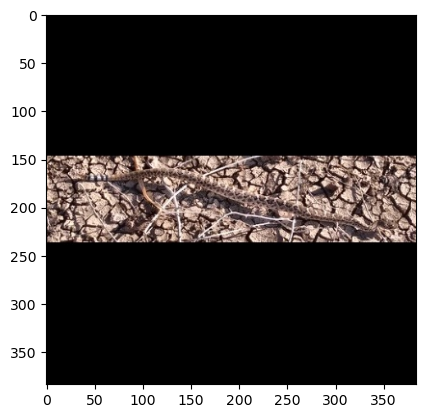

In [75]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(test_image_path)

plt.imshow(image)

In [81]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import StringDeserializer

predictor = Predictor(endpoint_name='snake-custom-endpoint')
predictor.serializer = IdentitySerializer(content_type='image/jpeg')
predictor.deserializer = StringDeserializer()

In [82]:
response = predictor.predict(payload)
print(response)

{"class_index": 4, "class_label": "Western Diamondback rattlesnake", "confidence": 0.765}


In [60]:
#predictor.delete_endpoint()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictor.delete_endpoint()                                                                  │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predictor' is not defined